In [3]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import viz_losses, viz_weights

from scipy.stats import entropy
from scipy.stats import ks_2samp

%load_ext autoreload
%autoreload 2

In [6]:
plt.style.use('fivethirtyeight')

import matplotlib as mpl
import matplotlib.pylab as pylab
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.linewidth'] = 3.
mpl.rcParams['grid.linewidth'] = 1.
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=3
pylab.rcParams['ytick.major.pad']=3

pylab.rcParams['figure.facecolor']='white'
pylab.rcParams['axes.facecolor']='white'
# mpl.rcParams['figure.figsize'] = [12, 10]
# mpl.rcParams.keys()
# Say, "the default sans-serif font is COMIC SANS"
# mpl.rcParams['font.serif'] = 'Times New Roman'
# # Then, "ALWAYS use sans-serif fonts"
# mpl.rcParams['font.family'] = "Serif"

# load results from a directory

In [9]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/sweep_full_real'
folder = ''

In [10]:
# depending on how much is saved, this may take a while
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'test'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

100%|██████████| 1500/1500 [00:14<00:00, 105.47it/s]


In [12]:
results.shape

(750, 44)

In [11]:
for i in tqdm(range(len(results))):
    results.accs_train[i] *= 100/results.batch_size[i]
    results.accs_test[i] *=  100/results.batch_size[i]

In [13]:
results['max_train_acc'] = np.array([max(results.accs_train[i]) for i in range(len(results)) ]) 
results['max_test_acc'] = np.array([max(results.accs_test[i]) for i in range(len(results)) ])

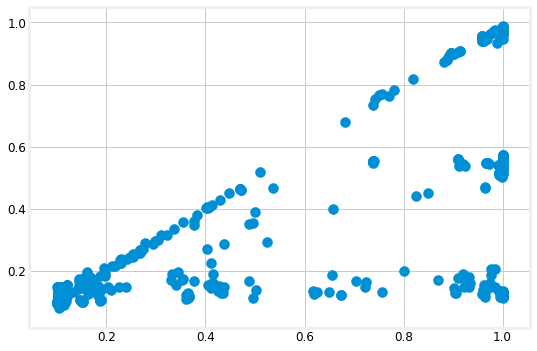

In [20]:
plt.scatter(results['max_train_acc'], results['max_test_acc'], marker='.')
plt.show()

In [115]:
ITS = results.its[0]

In [137]:
rg = results.groupby(['shuffle_labels', 'dset', 'optimizer', 'num_layers', 'lr', 'batch_size'])

In [138]:
labels_true_random = results.shuffle_labels.unique()
dsets = results.dset.unique()
optims = results.optimizer.unique()
num_layers = sorted(results.num_layers.unique())
lrs = sorted(results.lr.unique())
bss = sorted(results.batch_size.unique())

In [734]:
def plot_with_err(x, ymat, legend, onlyup=False, ythres=[None, None], scale='linear', f=1.,
                 linestyle='-', color=None):
    y = ymat.mean(axis=0)
    yerr = ymat.std(axis=0)
    
    ymin = y if onlyup else y-f*yerr
    ymax = y+f*yerr
    
    ymin = np.maximum(ymin, ythres[0]) if ythres[0] is not None else ymin
    ymax = np.minimum(ymax, ythres[1]) if ythres[1] is not None else ymax
    
    if color is None:
        plt.plot(x, y, label=legend, linestyle=linestyle)
        plt.fill_between(x, ymin, ymax, alpha=0.3)
    else:
        plt.plot(x, y, label=legend, linestyle=linestyle, color=color)
        plt.fill_between(x, ymin, ymax, alpha=0.3, color=color)
    if scale=='log':
        plt.yscale('log')
    return

def suptitle(grp, var_idx):
    ans = 'Effect of ' + param_labels[var_idx] +' (Fixed:'
    for i in range(len(grp)):
        if i != var_idx:
            if i==0:
                ans += ' True labels,' if not grp[i] else ' Random labels'
            else:
                ans +=  ' '+ str(grp[i])+','
    ans += ' )'

    return ans

def stable_rank(svals, key):
    sr_wts = np.zeros_like(svals)
    for j in range(svals.shape[0]):
        sr_wts[j] = np.array([ np.sum(svals[j, i][key]**2)/np.max(svals[j, i][key]**2)
            for i in range(len(ITS))])
    return np.asarray(sr_wts, 'float')

def soft_85(svals, key, percentile=0.85):
    sr_wts = np.zeros_like(svals)
    for j in range(svals.shape[0]):
        sr_wts[j] = np.array([
            1.*np.where(np.cumsum(svals[j, i][key]**2)
                     /np.sum(svals[j, i][key]**2) > percentile)[0][0] / len(svals[j, i][key])
            for i in range(len(ITS))])
    return np.asarray(sr_wts, 'float')

def cumsum(svals, key):
    sr_wts = np.zeros_like(svals)
    for j in range(svals.shape[0]):
        sr_wts[j] = np.array([ np.sum(svals[j, i][key]**2)/np.max(svals[j, i][key]**2)
            for i in range(len(ITS))])
    return np.asarray(sr_wts, 'float')

def basic_plot(grp, var_list, var_idx):
    fields = ['losses_train', 'losses_test', 'accs_train', 'accs_test']
    x = ITS
    plt.figure(figsize=[4*len(fields), 4])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
        except: 
            continue

        for i, field in enumerate(fields):
            temp = np.vstack(df_group[field])           
            plt.subplot(1, len(fields), i+1)

            if 'losses' in field:
                plot_with_err(ITS, temp, legend, onlyup=True, scale='log', f=1.)
            else:
                plot_with_err(ITS, temp, legend, onlyup=False, ythres=[0., 1.], scale='linear', f=1.)
            plt.legend()
            plt.title(field)
    plt.show()

    
def plot_accuracy_num_pcs(grp, var_list, var_idx, UPTO=None, percentile=0.85):
    if UPTO is None:
        UPTO = len(ITS)
    plt.figure(figsize=[5*3, 4])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list[:UPTO]):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
            if j>=1:
                plt.figure(figsize=[5*3, 4])
        except: 
            continue

        subtitle = ' '+ param_labels[var_idx] + ': ' + str(var)
        plt.subplot(1, 3, 1)
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_train'])[:, :UPTO], 'train')
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_test'])[:, :UPTO], 'test')
        plt.title('Accuracy' + subtitle)
        plt.ylim([-0.1, 1.1])
        plt.legend()

        weight_svals = np.vstack(df_group['singular_val_dicts_pca'])
        wkeys = sorted(weight_svals[0, 0].keys())

        act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])
        akeys = sorted(act_svals[0, 0].keys())

        for i, (wkey, akey) in enumerate(zip(wkeys, akeys)):
            plt.subplot(1, 3, 2)
            plot_with_err(ITS[:UPTO], soft_85(weight_svals, wkey, percentile)[:, :UPTO], str(wkey))
            if i==len(wkeys)-1:
                plt.legend()
                plt.title('Num pcs %d : Weights, '%(100*percentile)+subtitle)

            plt.subplot(1, 3, 3)
            plot_with_err(ITS[:UPTO], soft_85(act_svals, akey, percentile)[:, :UPTO], str(akey))
            if i==len(wkeys)-1:
                plt.legend()
                plt.title('Num pcs %d : Activations,'%(100*percentile)+subtitle)
    plt.show()
    
def plot_margins(grp, var_list, var_idx, UPTO=None):
    if UPTO is None:
        UPTO = len(var_list)
    plt.figure(figsize=[4*2, 4])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list[:UPTO]):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
        except: 
            continue

        plt.subplot(121)
        plt.plot(ITS[:UPTO], np.vstack(df_group['mean_margin_train_unnormalized']).mean(axis=0), 
                 label=legend+'-train')
        plt.plot(ITS[:UPTO], np.vstack(df_group['mean_margin_test_unnormalized']).mean(axis=0), 
                 label=legend+'-test')
        plt.title('mean margin UN-normalized')
        plt.legend()

        plt.subplot(122)
        plt.plot(ITS[:UPTO], np.vstack(df_group['mean_margin_train']).mean(axis=0)*100/df_group.batch_size.mean(axis=0), 
                 label=legend+'-train')
        plt.plot(ITS[:UPTO], np.vstack(df_group['mean_margin_test']).mean(axis=0)*100/df_group.batch_size.mean(axis=0), 
                 label=legend+'-test')
        plt.title('mean margin normalized')
        plt.legend()

    plt.show()
def compare_accuracy_stable_rank(grp, var_list, var_idx, UPTO=None, ):
    assert(var_idx != 3)
    if UPTO is None:
        UPTO = len(ITS)

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    plt.figure(figsize=[6, 5])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
        except: 
            continue

        subtitle = ' '+ param_labels[var_idx] + ': ' + str(var)
        plt.subplot(1,1,1)
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_train'])[:, :UPTO], legend+' train',
                     linestyle='-', color=colors[j])
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_test'])[:, :UPTO], legend+' test',
                     linestyle='--', color=colors[j])
    plt.title('Accuracy')
    plt.ylim([-0.1, 1.1])
    plt.legend()
        
    plt.show()

    weight_svals = np.vstack(df_group['singular_val_dicts_pca'])
    wkeys = sorted(weight_svals[0, 0].keys())
    
    act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])
    akeys = sorted(act_svals[0, 0].keys())
    
    for i, (wkey, akey) in enumerate(zip(wkeys, akeys)):
        plt.figure(figsize=[4*2, 4])
        
        for j, var in enumerate(var_list):
            grp[var_idx] = var
            try:
                df_group = rg.get_group(tuple(grp))
                legend = param_labels[var_idx] + ' ' + str(var)
            except: 
                continue

            weight_svals = np.vstack(df_group['singular_val_dicts_pca'])

            act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])

            plt.subplot(1, 2, 1)
            plot_with_err(ITS[:UPTO], stable_rank(weight_svals, wkey)[:, :UPTO], legend)
            plt.title('Stable rank weights:' + wkey)
            plt.legend()

            plt.subplot(1, 2, 2)
            plot_with_err(ITS[:UPTO], stable_rank(act_svals, akey)[:, :UPTO], legend)
            plt.title('Stable rank activations:' + akey)
            plt.legend()
        plt.show()
        
def compare_accuracy_soft85(grp, var_list, var_idx, UPTO=None, percentile=0.85):
    assert(var_idx != 3)
    if UPTO is None:
        UPTO = len(ITS)


    plt.figure(figsize=[6, 5])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
        except: 
            continue

        subtitle = ' '+ param_labels[var_idx] + ': ' + str(var)
        plt.subplot(1,1,1)
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_train'])[:, :UPTO], legend+' train',
                     linestyle='-', color=colors[j])
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_test'])[:, :UPTO], legend+' test',
                     linestyle='--', color=colors[j])
    plt.title('Accuracy')
    plt.ylim([-0.1, 1.1])
    plt.legend()
        
    plt.show()

    weight_svals = np.vstack(df_group['singular_val_dicts_pca'])
    wkeys = sorted(weight_svals[0, 0].keys())
    
    act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])
    akeys = sorted(act_svals[0, 0].keys())
    
    for i, (wkey, akey) in enumerate(zip(wkeys, akeys)):
        plt.figure(figsize=[4*2, 4])
        
        for j, var in enumerate(var_list):
            grp[var_idx] = var
            try:
                df_group = rg.get_group(tuple(grp))
                legend = param_labels[var_idx] + ' ' + str(var)
            except: 
                continue

            weight_svals = np.vstack(df_group['singular_val_dicts_pca'])

            act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])

            plt.subplot(1, 2, 1)
            plot_with_err(ITS[:UPTO], soft_85(weight_svals, wkey, percentile)[:, :UPTO], legend)
            plt.title('Num PC: %d '%(100*percentile)+wkey)
            plt.legend()

            plt.subplot(1, 2, 2)
            plot_with_err(ITS[:UPTO], soft_85(act_svals, akey, percentile)[:, :UPTO], legend)
            plt.title('Num PC: %d '%(100*percentile)+akey)
            plt.legend()
        plt.show()
        
def plot_init_and_final_hist(grp, var_list, var_idx):
    plt.figure(figsize=[6, 5])
    plt.suptitle(suptitle(grp, var_idx))
    for j, var in enumerate(var_list):
        grp[var_idx] = var
        try:
            df_group = rg.get_group(tuple(grp))
            legend = param_labels[var_idx] + ' ' + str(var)
        except: 
            continue

        subtitle = ' '+ param_labels[var_idx] + ': ' + str(var)
        plt.subplot(1,1,1)
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_train'])[:, :UPTO], legend+' train',
                     linestyle='-', color=colors[j])
        plot_with_err(ITS[:UPTO], np.vstack(df_group['accs_test'])[:, :UPTO], legend+' test',
                     linestyle='--', color=colors[j])
    plt.title('Accuracy')
    plt.ylim([-0.1, 1.1])
    plt.legend()
        
    plt.show()

    weight_svals = np.vstack(df_group['singular_val_dicts_pca'])
    wkeys = sorted(weight_svals[0, 0].keys())
    
    act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])
    akeys = sorted(act_svals[0, 0].keys())
    
    for j, var in enumerate(var_list):
        for i, (wkey, akey) in enumerate(zip(wkeys, akeys)):
        
            plt.figure(figsize=[4*4, 4])
            grp[var_idx] = var
            try:
                df_group = rg.get_group(tuple(grp))
                legend = param_labels[var_idx] + ' ' + str(var)
            except: 
                continue

            weight_svals = np.vstack(df_group['singular_val_dicts_pca'])

            act_svals = np.vstack(df_group['act_singular_val_dicts_test_pca'])

            plt.subplot(1, 4, 1)
            plt.hist([weight_svals[0, 0][wkey]], bins=20)
            plt.title(legend+wkey+' initial')
            
            plt.subplot(1, 4, 2)
            plt.hist([weight_svals[0, -1][wkey]], bins=20)
            plt.title(legend+wkey+' final')


            plt.subplot(1, 4, 3)
            plt.hist([act_svals[0, 0][akey]], bins=20)
            plt.title(legend+akey+' initial')
            
            plt.subplot(1, 4, 4)
            plt.hist([act_svals[0, -1][akey]], bins=20)
            plt.title(legend+akey+' final')
            plt.show()

In [540]:
param_labels = ['data labels', 'dset', 'optimizer', 
                 'no of layers', 'step size', 'batch size']
vary_dict = {'data labels': labels_true_random, 'dset':dsets, 'optimizer':optims,
                     'num_layers':num_layers, 'step_size':lrs, 'batch_size':bss}
vary_dict_idx = {'data labels': 0, 'dset':1, 'optimizer':2,
                     'num_layers':3, 'step_size':4, 'batch_size':5}

# Things to Tweak

In [808]:
param_to_vary = 'batch_size' # change this based on vary_dict

# and set the other variables here
labels, dset, opt = False, 'mnist', 'sgd'
num_layer, lr, bs = 4, .1, 100
var_idx = vary_dict_idx[param_to_vary]
var_list = vary_dict[param_to_vary]
grp = [labels, dset, opt, num_layer, lr, bs]

# The code below is auto-pilot

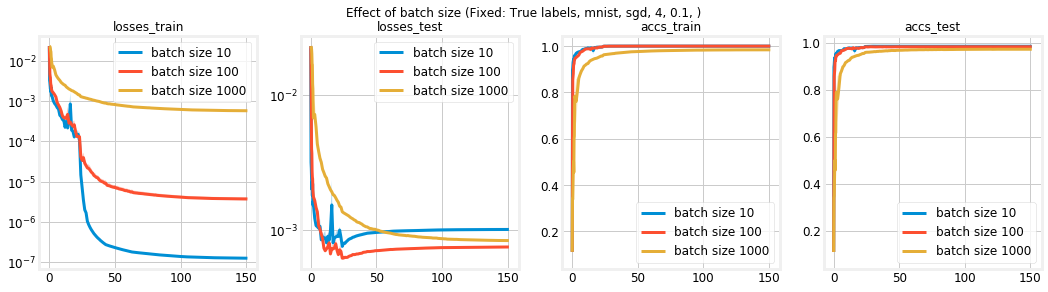

In [809]:
basic_plot(grp, var_list, var_idx)

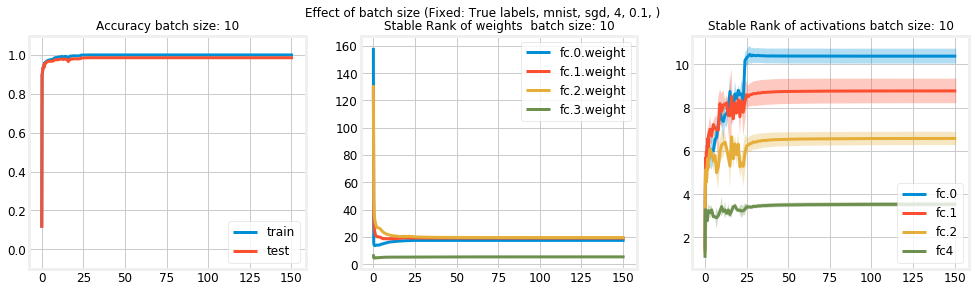

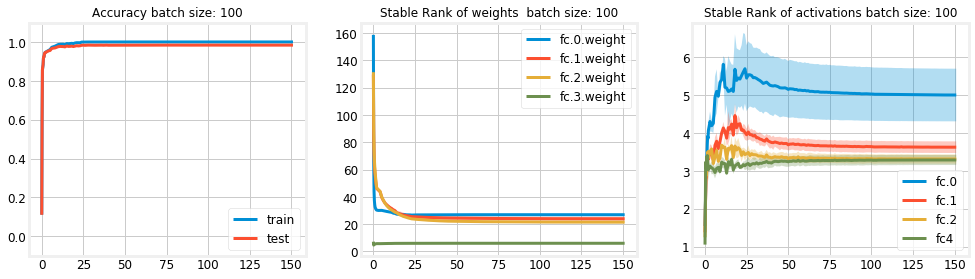

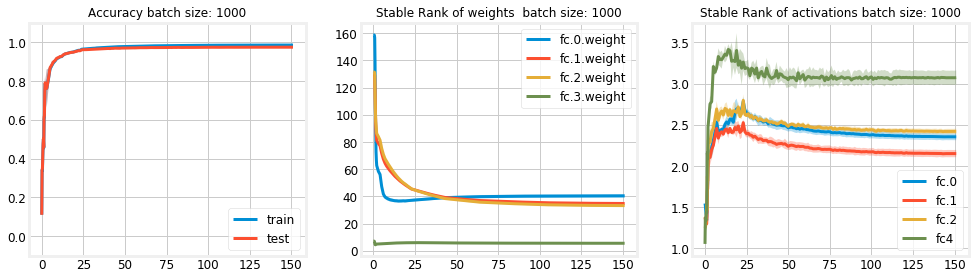

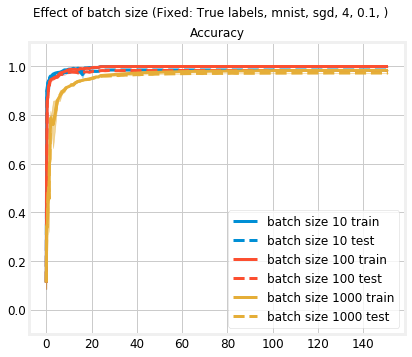

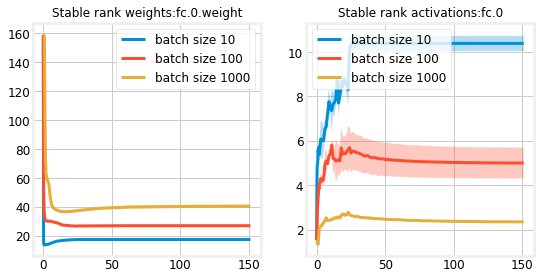

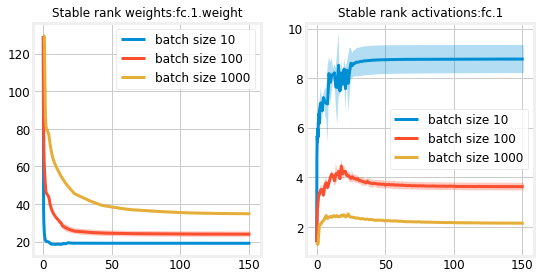

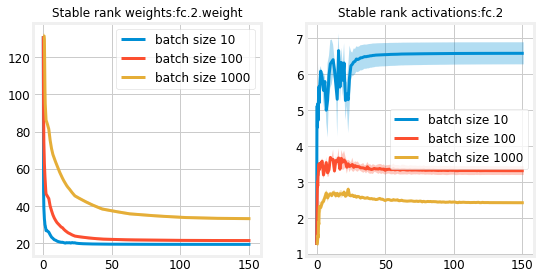

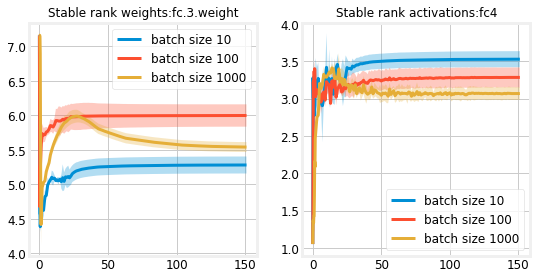

In [810]:
UPTO = len(ITS)
plot_accuracy_stable_rank(grp, var_list, var_idx, UPTO)

compare_accuracy_stable_rank(grp, var_list, var_idx, UPTO) 
## use the second function if you want to see effect of the variable across layers
## num of layers has to be fixed

## Additional plots



In [780]:
grp[5] = 100

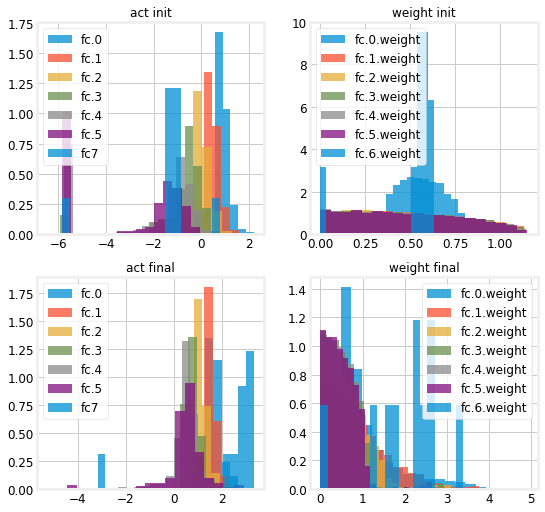

fc.0 164.616 486.201
fc.1 84.2836 211.758
fc.2 47.8739 190.05
fc.3 34.11 262.06
fc.4 31.0008 452.879
fc.5 31.7051 812.988
fc7 6.16064 2199.97

fc.0.weight 0.808118 4.91558
fc.1.weight 1.13538 3.77308
fc.2.weight 1.14164 3.09168
fc.3.weight 1.13654 2.93118
fc.4.weight 1.14675 2.6427
fc.5.weight 1.15393 2.64223
fc.6.weight 0.630864 3.38884


In [798]:
df_group= rg.get_group(tuple(grp))
temp = np.vstack(df_group.act_singular_val_dicts_test_pca)
temp2 = np.vstack(df_group.singular_val_dicts_pca)


plt.figure(figsize=[8, 8])
plt.subplot(221)
for akey in sorted(temp[0, 0].keys()):
    plt.hist(np.log10(temp[0, 0][akey]), label=akey, bins=20, normed=True, alpha=0.75)
plt.legend()
plt.title('act init')

plt.subplot(223)
for akey in sorted(temp[0, -1].keys()):
    plt.hist(np.log10(temp[0, -1][akey]), label=akey, bins=20, normed=True, alpha=0.75)
plt.legend()
plt.title('act final')

plt.subplot(222)
for wkey in sorted(temp2[0, 0].keys()):
    plt.hist((temp2[0, 0][wkey]), label=wkey, bins=20, normed=True, alpha=0.75)
plt.legend()
plt.title('weight init')

plt.subplot(224)
for wkey in sorted(temp2[0, -1].keys()):
    plt.hist((temp2[0, -1][wkey]), label=wkey, bins=20, normed=True, alpha=0.75)
plt.legend()
plt.title('weight final')


plt.show()

for akey in sorted(temp[0, 0].keys()):
    print(akey, max(temp[0, 0][akey]), max(temp[0, -1][akey]))
print('')
for wkey in sorted(temp2[0, 0].keys()):
    print(wkey, max(temp2[0, 0][wkey]), max(temp2[0, -1][wkey]))

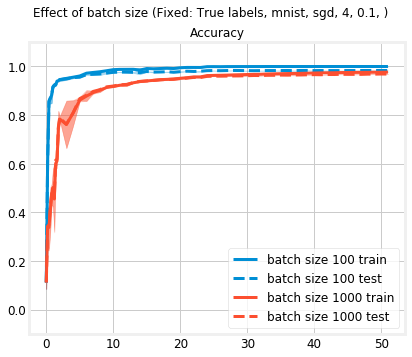

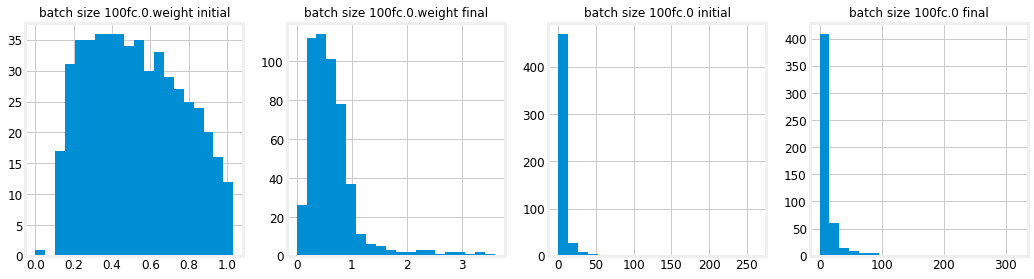

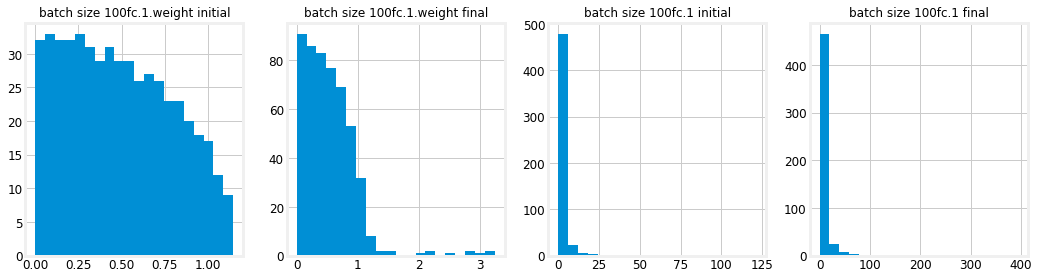

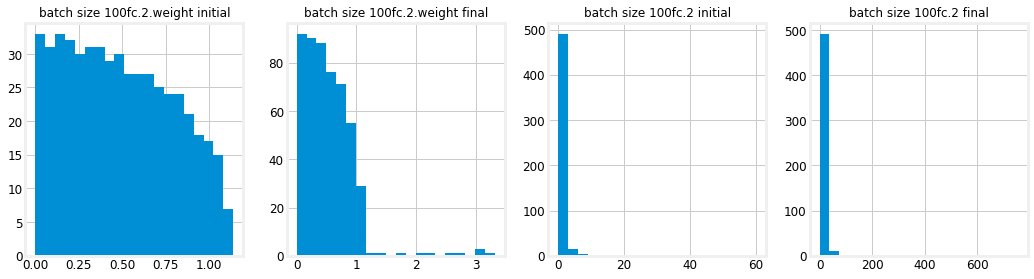

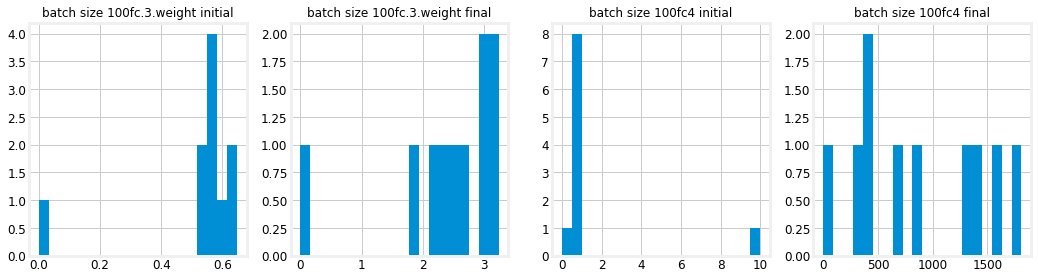

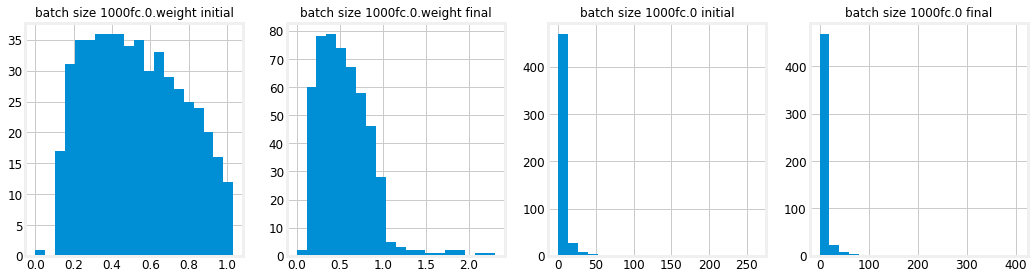

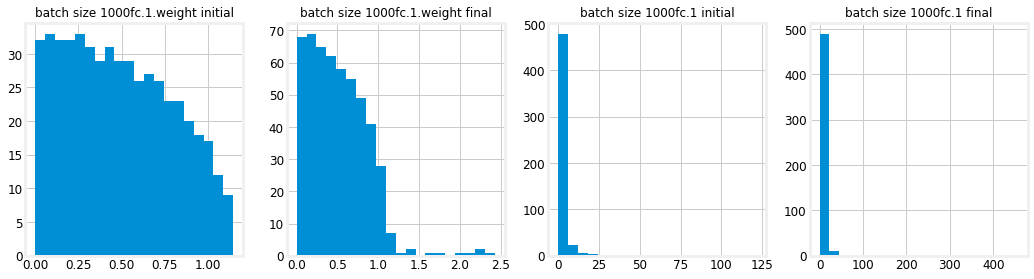

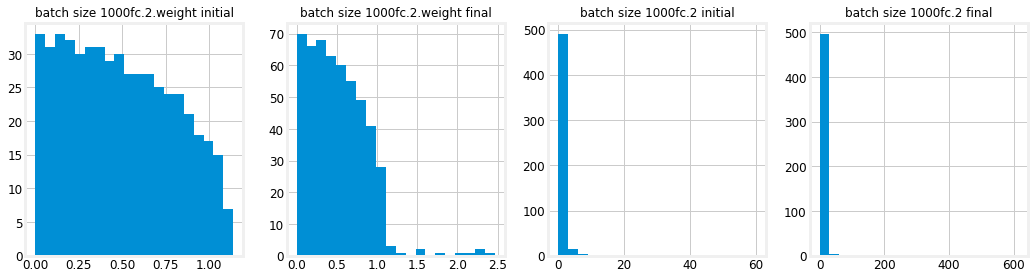

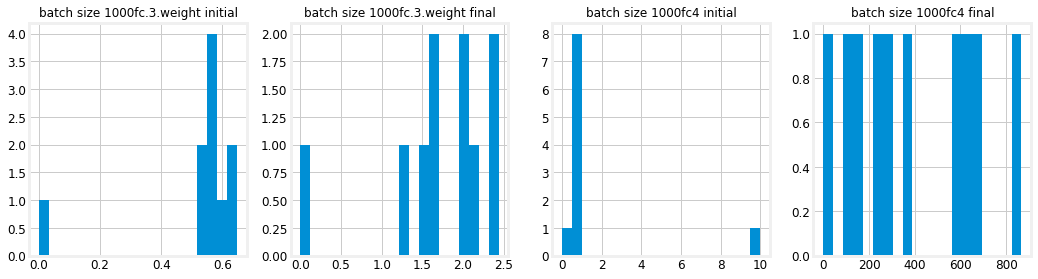

In [747]:
# histogram of initial and final singular values

plot_init_and_final_hist(grp, var_list[1:3], var_idx)

In [714]:
UPTO = 60
percentile = 0.8
# plot_accuracy_num_pcs(grp, var_list, var_idx, UPTO, percentile)
# compare_accuracy_soft85(grp, var_list, var_idx, UPTO, percentile) 

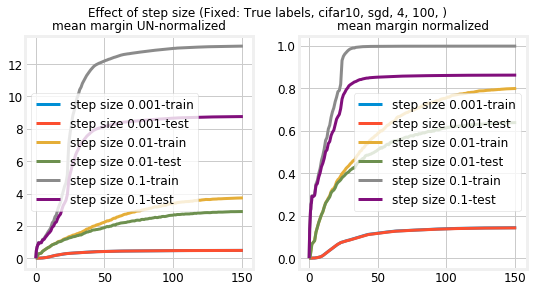

In [706]:
x = ITS
UPTO = len(ITS)
plot_margins(grp, var_list, var_idx, UPTO)